In [23]:
import pandas as pd
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

from scipy.cluster.hierarchy import dendrogram, linkage

In [3]:
clases = pd.read_csv('classes.csv')

In [4]:
clases_filtred = clases[clases['filename'].str.contains(r'^[a-zA-Z0-9_/\-.]+$', regex=True)]
clases_filtred['path'] = 'archive/' + clases_filtred['filename']

imagenes_random = clases_filtred['path'].sample(n=1000, random_state=42)

/var/folders/18/88x5gxxj0wq949rkr1_qj3_45113mn/T/ipykernel_96826/777794092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clases_filtred['path'] = 'archive/' + clases_filtred['filename']


Despues de varias pruebas y buscarle sentido a fitear el modelo con muchas imagenes, descubrí que no tiene sentido
ya que la idea es buscar los "centrides" de las imagenes y para eso solo se necesita una imagen a la vez por cada iteracion de entrenamiento.

In [14]:
images_random = clases_filtred['path'].sample(n=3)

In [15]:
images = []
for ima in  images_random:
    image = cv2.imread(ima)
    image_resized = cv2.resize(image, (224,224), interpolation=cv2.INTER_AREA)
    images.append(image_resized)

In [16]:
def silhouette(X, k_min=5, k_max=7):

    scores = []
    for i in range(k_min, k_max+1):
        
        model_k = KMeans(n_clusters=i)
        model_k.fit(X)
        # Almacenamos el coeficiente de la silueta
        score = silhouette_score(X, model_k.labels_)
        scores.append(score)

    max_scores = max(scores)
    print(max_scores)
    return scores.index(max_scores)+k_min
    

0.3236817915448608
5


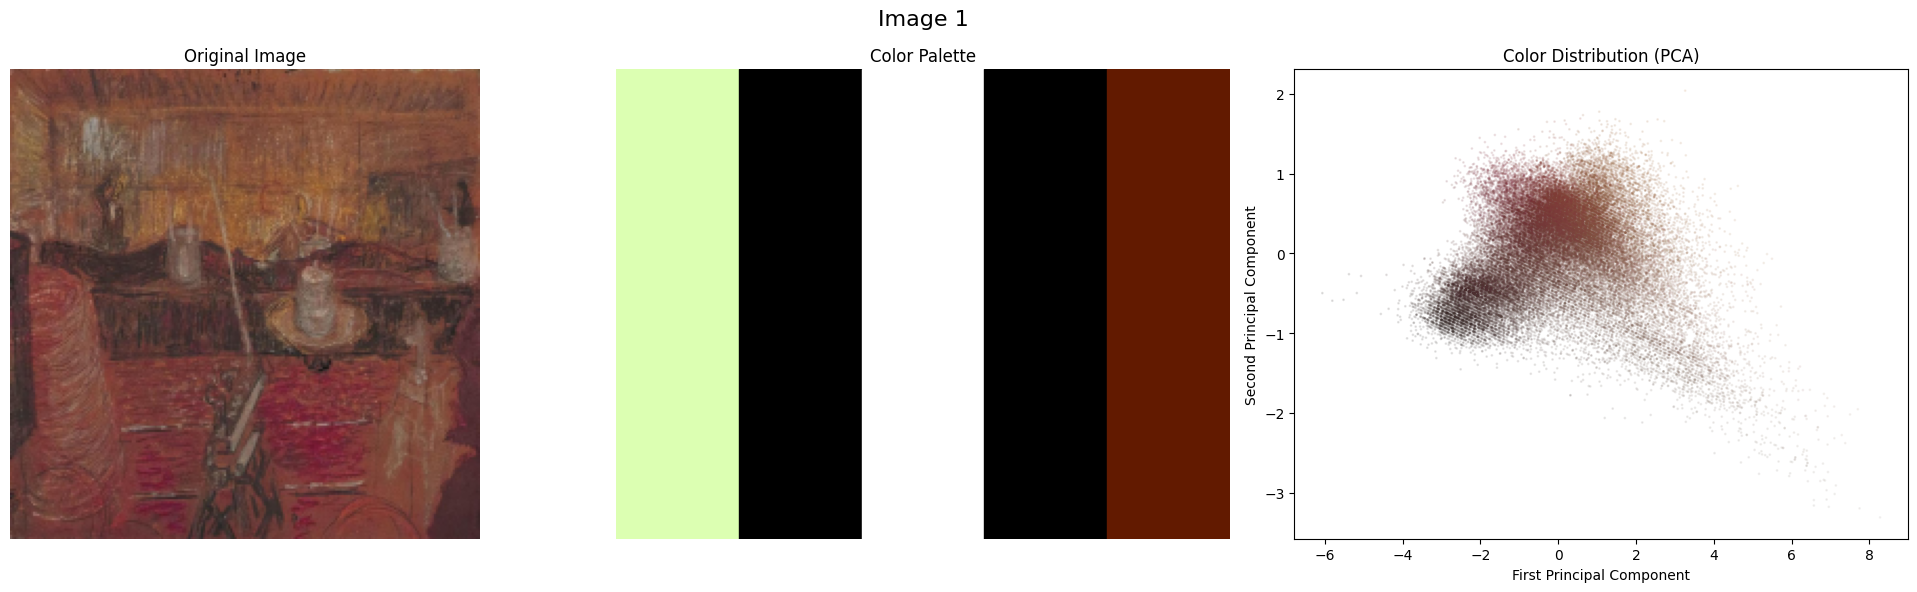

0.624549318904155
6


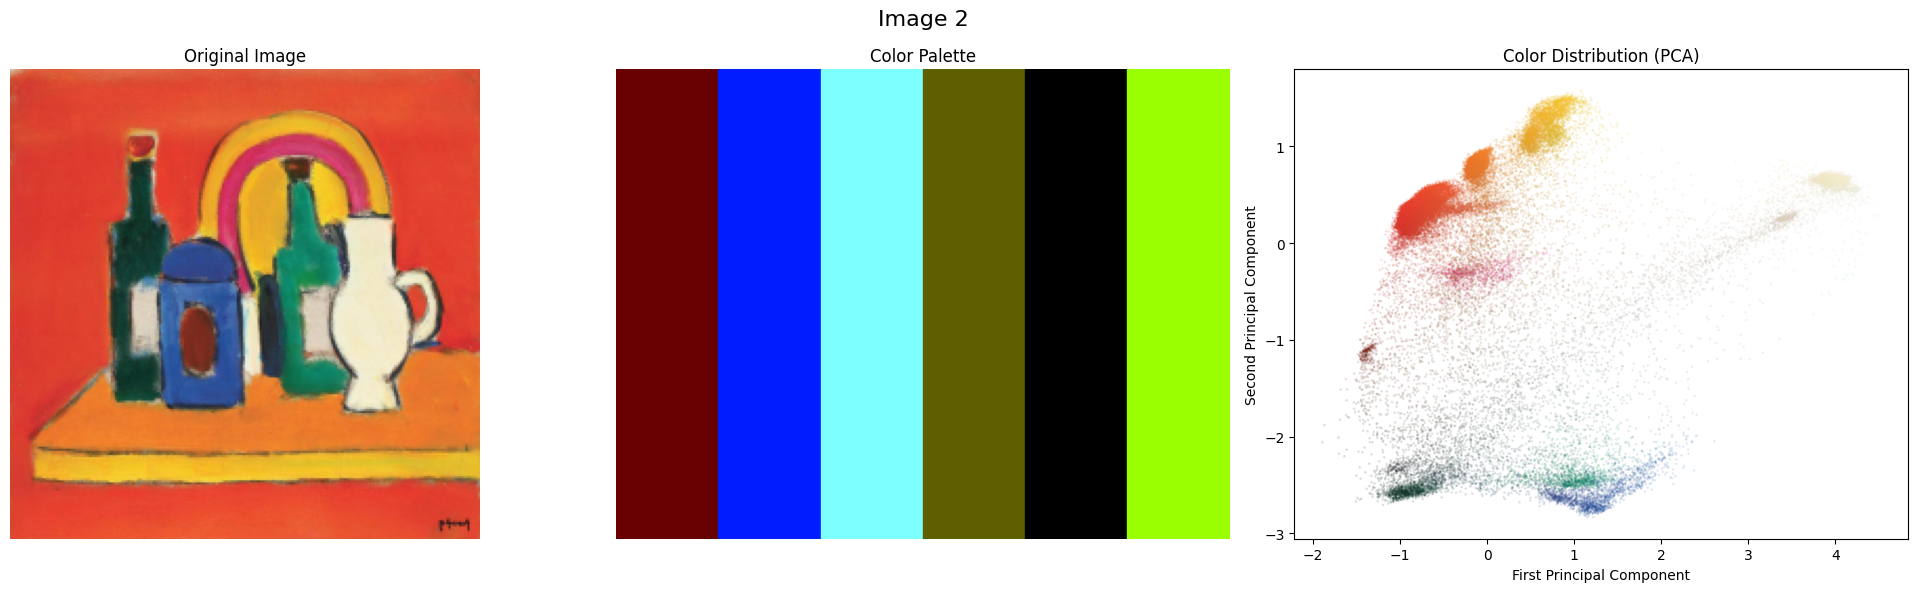

0.535629483795556
5


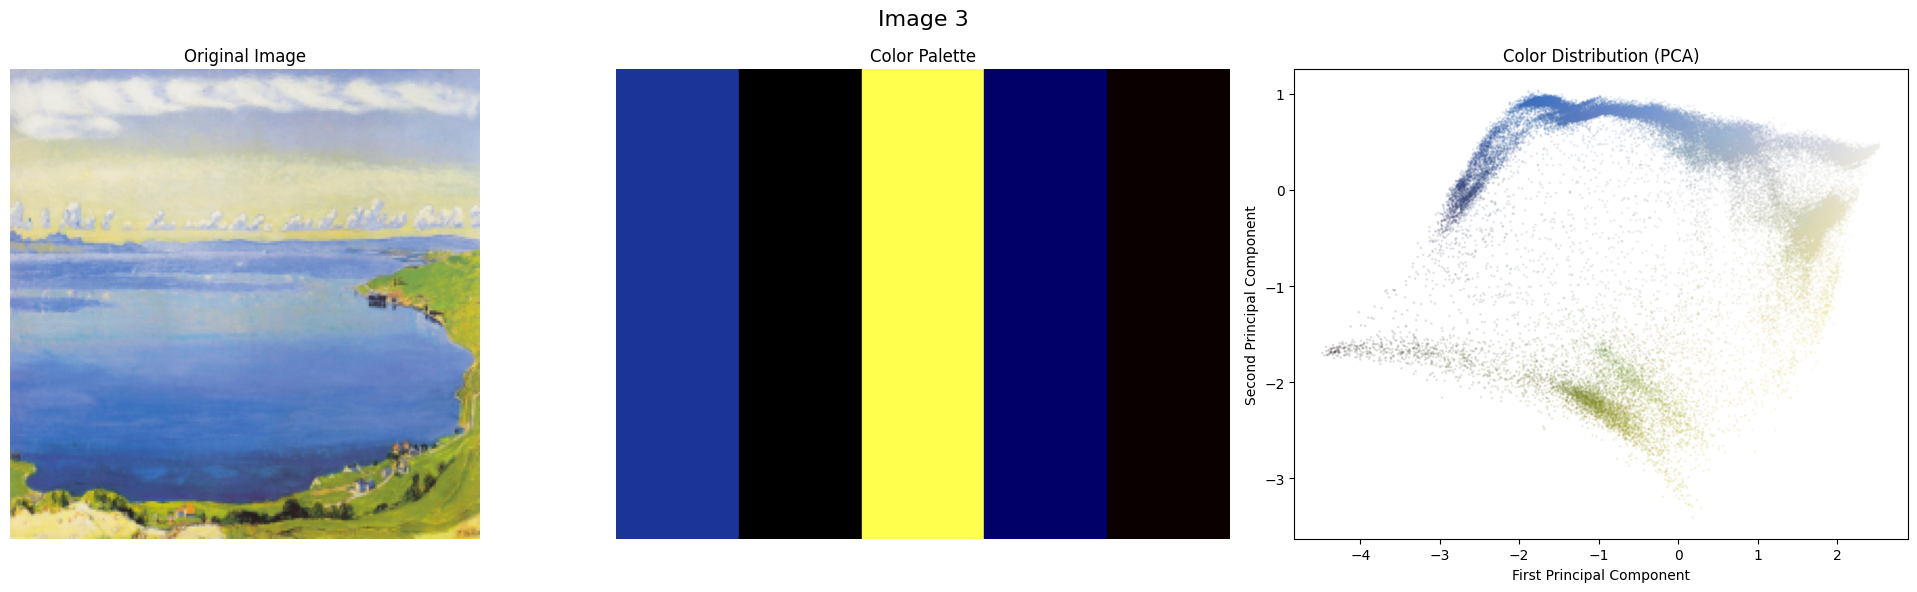

In [21]:
def show_image_and_palette(image, title):
      
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    ima = image_rgb.reshape(-1, 3)
    scaler = StandardScaler()
    normalized_imag = scaler.fit_transform(ima)

    # no sirve
    k_silhouette = silhouette(normalized_imag)
    print(k_silhouette)

    kmeans = KMeans(n_clusters=k_silhouette, random_state=42)


    kmeans.fit(normalized_imag)

    colors = kmeans.cluster_centers_
    colors = np.clip(colors * 255, 0, 255).astype(int)


    pca = PCA(n_components=2)
    pixels_2d = pca.fit_transform(normalized_imag)
    
    #unque_colors = np.unique(colors, axis=0)
    #unque_colors = colors
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(title, fontsize=16)
    ax1.imshow(image_rgb)
    ax1.axis('off')
    ax1.set_title('Original Image')


    for i, color in enumerate(colors):
        ax2.axvspan(i, i+1, color=color/255)
    ax2.set_xlim(0, len(colors))
    ax2.axis('off')
    ax2.set_title('Color Palette')

    ax3.scatter(pixels_2d[:, 0], pixels_2d[:, 1], c=ima/255, s=1, alpha=0.1)
    ax3.set_title('Color Distribution (PCA)')
    ax3.set_xlabel('First Principal Component')
    ax3.set_ylabel('Second Principal Component')

    plt.tight_layout()
    plt.show()

    return colors



palettes = []
titles = []

for i, image in enumerate(images):
    title = f"Image {i+1}"
    palette = show_image_and_palette(image, title)
    if palette is not None:
        palettes.append(palette)
        titles.append(title)



In [129]:
#fin

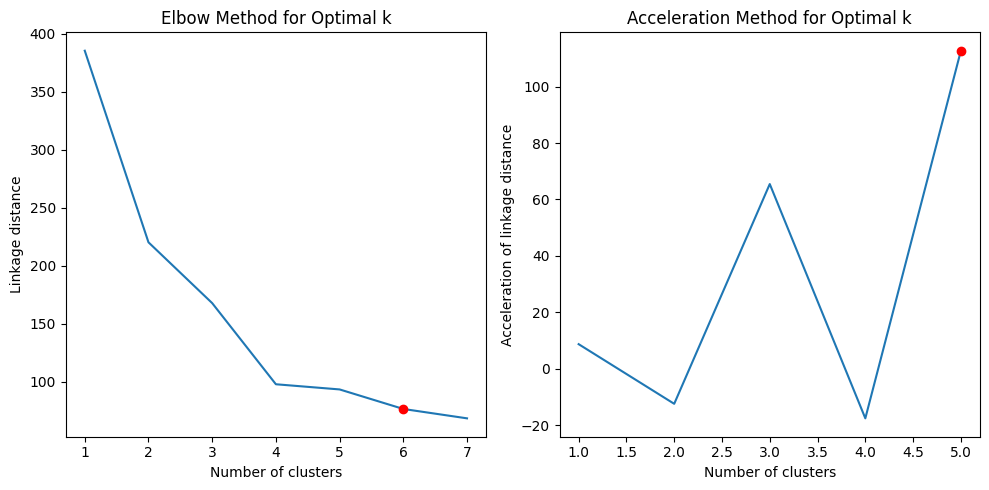

Optimal number of clusters for Image 1: 6


/opt/anaconda3/envs/maestria/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/maestria/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/var/folders/18/88x5gxxj0wq949rkr1_qj3_45113mn/T/ipykernel_96826/1972999232.py:64: RuntimeWarning: invalid value encountered in cast
  colors = np.clip(colors, 0, 255).astype(int)


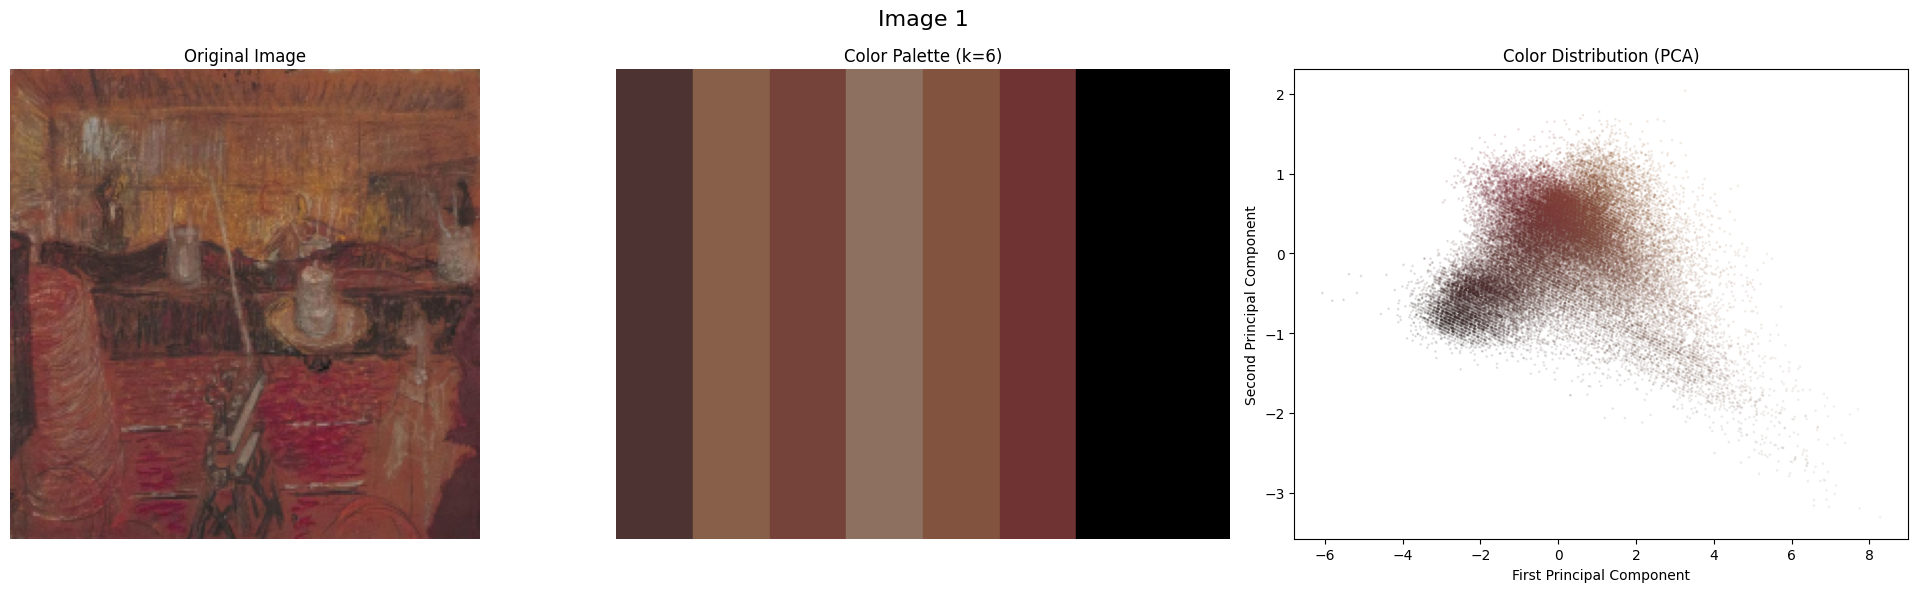

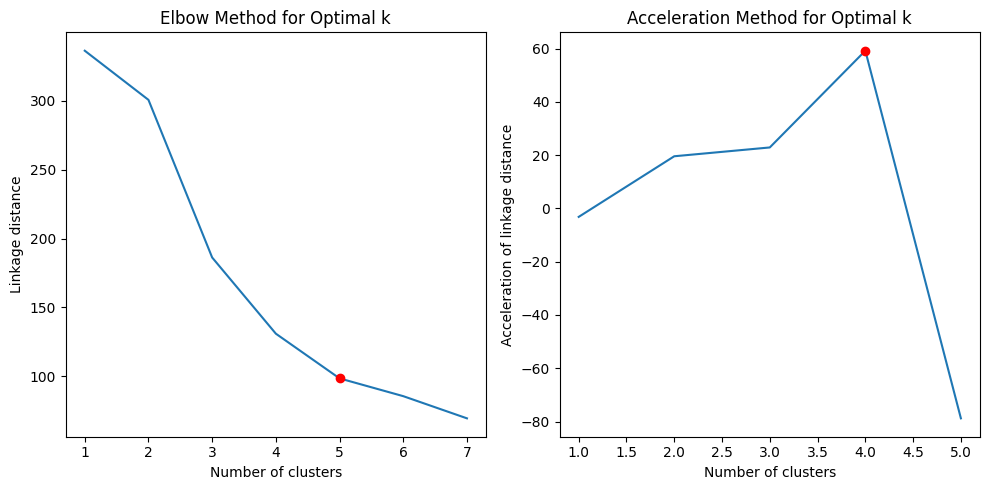

Optimal number of clusters for Image 2: 5


/opt/anaconda3/envs/maestria/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/maestria/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/var/folders/18/88x5gxxj0wq949rkr1_qj3_45113mn/T/ipykernel_96826/1972999232.py:64: RuntimeWarning: invalid value encountered in cast
  colors = np.clip(colors, 0, 255).astype(int)


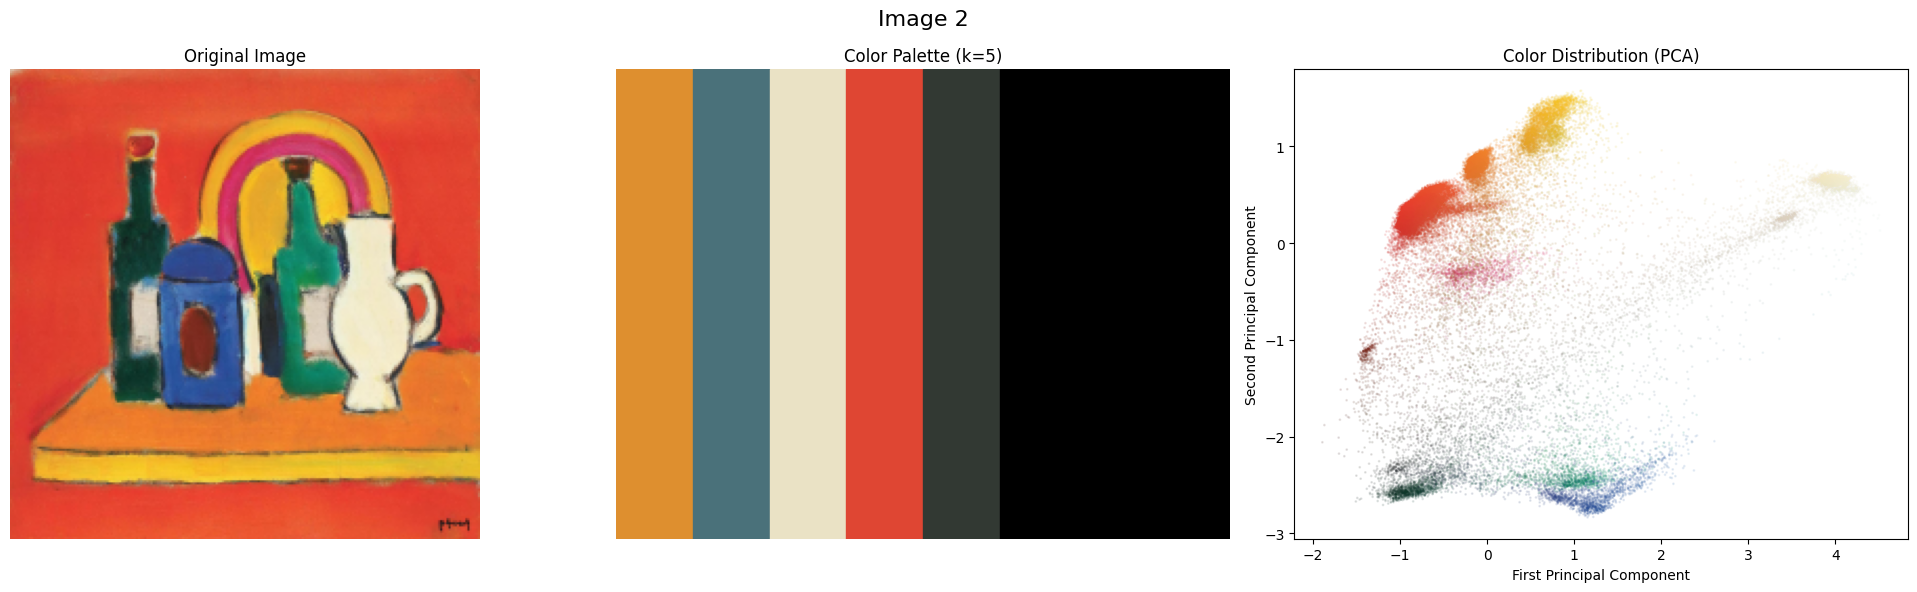

KeyboardInterrupt: 

In [24]:
def optimal_cluster_number(data, max_clusters=7):
    n_samples, n_features = data.shape
    
    # Calcular la matriz de enlace
    linkage_matrix = linkage(data, method='ward')
    
    # Calcular las distancias de enlace para diferentes números de clusters
    last = linkage_matrix[-max_clusters:, 2]
    last_rev = last[::-1]
    idxs = np.arange(1, len(last) + 1)
    
    # Calcular la aceleración de la curva
    acceleration = np.diff(last_rev, 2)
    acceleration_rev = acceleration[::-1]
    
    k = acceleration_rev.argmax() + 2  # El número óptimo de clusters
    
    # Visualizar el método del codo
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(idxs, last_rev)
    plt.plot(idxs[k-1], last_rev[k-1], 'ro')
    plt.xlabel('Number of clusters')
    plt.ylabel('Linkage distance')
    plt.title('Elbow Method for Optimal k')
    
    # Visualizar la aceleración
    plt.subplot(122)
    plt.plot(idxs[:-2], acceleration_rev)
    plt.plot(idxs[k-2], acceleration_rev[k-2], 'ro')
    plt.xlabel('Number of clusters')
    plt.ylabel('Acceleration of linkage distance')
    plt.title('Acceleration Method for Optimal k')
    
    plt.tight_layout()
    plt.show()
    
    return k


def show_image_and_palette(image, title):
      
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    

    ima = image_rgb.reshape(-1, 3)
    scaler = StandardScaler()
    normalized_imag = scaler.fit_transform(ima)

    n_colors = optimal_cluster_number(normalized_imag)
    print(f"Optimal number of clusters for {title}: {n_colors}")

    agglo = AgglomerativeClustering(n_clusters=n_colors)
    agglo.fit(normalized_imag)

    colors = []
    for i in range(8):
        cluster_pixels = ima[agglo.labels_ == i]
        avg_color = np.mean(cluster_pixels, axis=0)
        colors.append(avg_color)

    
    colors = np.array(colors)
    colors = np.clip(colors, 0, 255).astype(int)

    # Aplicar PCA
    pca = PCA(n_components=2)
    pixels_2d = pca.fit_transform(normalized_imag)

    # Crear la visualización
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(title, fontsize=16)

    # Mostrar la imagen original
    ax1.imshow(image_rgb)
    ax1.axis('off')
    ax1.set_title('Original Image')

    # Mostrar la paleta de colores
    for i, color in enumerate(colors):
        ax2.axvspan(i, i+1, color=color/255)
    ax2.set_xlim(0, len(colors))
    ax2.axis('off')
    ax2.set_title(f'Color Palette (k={n_colors})')

    # Visualizar la distribución de colores con PCA
    ax3.scatter(pixels_2d[:, 0], pixels_2d[:, 1], c=ima/255, s=1, alpha=0.1)
    ax3.set_title('Color Distribution (PCA)')
    ax3.set_xlabel('First Principal Component')
    ax3.set_ylabel('Second Principal Component')

    plt.tight_layout()
    plt.show()

    return colors



palettes = []
titles = []

for i, image in enumerate(images):
    title = f"Image {i+1}"
    palette = show_image_and_palette(image, title)
    if palette is not None:
        palettes.append(palette)
        titles.append(title)

In [25]:
palettes

[array([[ 77,  51,  49],
        [136,  96,  74],
        [117,  67,  58],
        [141, 112,  96],
        [130,  83,  63],
        [111,  51,  52],
        [  0,   0,   0],
        [  0,   0,   0]]),
 array([[222, 143,  47],
        [ 74, 113, 122],
        [234, 226, 197],
        [223,  70,  51],
        [ 50,  57,  51],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]])]